### Validation of the heat model with the Tabula Database

Import all relevant modules

In [1]:
import os
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tsib.timeseriesmanager as tsm
import tsib.buildingmodel as bdg
import tsib.buildingmanager as bm
import tsib.buildingconfig as cfg
import tsib.thermal.utils as utils
import tsib.data

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [4]:
import numpy as np

In [5]:
EXPORT_PATH = os.path.join('plots')

In [6]:
plt.style.use(os.path.join(os.getcwd(), 'diss.mplstyle'))

### Preprocess tabula data set

Read in tabula data

In [7]:
buildingSet = pd.read_csv(os.path.join(tsib.data.PATH, 'IWU', 'IWU_full.csv'),
                             header = 0, index_col = 0,)

In [8]:
buildingSet = buildingSet.ix[:-2]

C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


### Read in relevant building data

Read input data

In [9]:
try_data, loc = tsm.readTRY(try_num=4)

Add new column

In [10]:
buildingSet['q_sim'] = 0

Init building manager

In [11]:
boptmanager = bm.BuildingOptManager(datapath = 'results')

Init all buildings with small correction in the internal heat gain

In [12]:
bdgList = []
for ID in buildingSet.index:
    bdgcfg = cfg.BuildingConfiguration({'ID':ID, 'weather_data': try_data, 'weatherID': 'TRY_4',
                                       'refurbishment': False, 'nightReduction': False, 
                                       'occControl': False, 'capControl': True,'n_persons': 2,
                                       'comfortT_lb': 20.0, 'comfortT_ub': 26.0, 'roofOrientation': 0.0,})
    bdgObj = bdg.Building(configurator = bdgcfg, refurbishment = False)
    # manipulate internal gains with tabula mean value
    bdgObj.cfg['Q_ig'] = bdgObj.cfg['Q_ig'] * 15.552 / (bdgObj.cfg['Q_ig'].sum()/bdgObj.cfg['A_ref'])
    bdgList.append(bdgObj)

c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:247: UserWarning: longitude and latitude are set to default values. It can cause an error in the solar irration simulation
  'default values. It can cause an error in '
c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:284: UserWarning: number of app. "n_apartments" is inherited from IWU
  warnings.warn('number of app. "n_apartments" is inherited from IWU')


In [13]:
bdgListNight = []
for ID in buildingSet.index:
    bdgcfg = cfg.BuildingConfiguration({'ID':ID, 'weather_data': try_data, 'weatherID': 'TRY_4',
                                       'refurbishment': False, 'nightReduction': True, 
                                       'occControl': False, 'capControl': True,'n_persons': 2,
                                       'comfortT_lb': 20.0, 'comfortT_ub': 26.0, 'roofOrientation': 0.0,})
    bdgObj = bdg.Building(configurator = bdgcfg, refurbishment = False)
    # manipulate internal gains with tabula mean value
    bdgObj.cfg['Q_ig'] = bdgObj.cfg['Q_ig'] * 15.552 / (bdgObj.cfg['Q_ig'].sum()/bdgObj.cfg['A_ref'])
    bdgListNight.append(bdgObj)

c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:247: UserWarning: longitude and latitude are set to default values. It can cause an error in the solar irration simulation
  'default values. It can cause an error in '
c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:284: UserWarning: number of app. "n_apartments" is inherited from IWU
  warnings.warn('number of app. "n_apartments" is inherited from IWU')


In [14]:
bdgObj.cfg['Q_ig']

array([3.93558027, 4.46319721, 4.70734158, ..., 8.50507114, 6.90423774,
       7.0668998 ])

In [15]:
bdgOccList = []
for ID in buildingSet.index:
    bdgcfg = cfg.BuildingConfiguration({'ID':ID, 'weather_data': try_data, 'weatherID': 'TRY_4',
                                       'refurbishment': False, 'nightReduction': True, 
                                       'occControl': True, 'capControl': True,'n_persons': 2,
                                       'comfortT_lb': 20.0, 'comfortT_ub':26., 'roofOrientation':0.0,})
    bdgObj = bdg.Building(configurator = bdgcfg, refurbishment = False)
    # manipulate internal gains with tabula mean value
    bdgObj.cfg['Q_ig'] = bdgObj.cfg['Q_ig'] * 15.552 / (bdgObj.cfg['Q_ig'].sum()/bdgObj.cfg['A_ref'])
    bdgOccList.append(bdgObj)

c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:247: UserWarning: longitude and latitude are set to default values. It can cause an error in the solar irration simulation
  'default values. It can cause an error in '
c:\users\l.kotzur\sciebo\fzj\01_fullstateeco\tsib\tsib\buildingconfig.py:284: UserWarning: number of app. "n_apartments" is inherited from IWU
  warnings.warn('number of app. "n_apartments" is inherited from IWU')


## Optimize or get all building simulations

In [16]:
bdgs = boptmanager.getOpti(bdgList, case = 'profiles')

Duration for getting the results: 401.46879053115845


In [17]:
bdgsOcc = boptmanager.getOpti(bdgOccList, case = 'profiles')

Duration for getting the results: 10.667827367782593


In [18]:
bdgsNight = boptmanager.getOpti(bdgListNight, case = 'profiles')

Duration for getting the results: 10.945793151855469


In [19]:
for i,ID in enumerate(buildingSet.index):
    buildingSet.loc[ID,'q_sim'] = bdgs[i].detailed_results['Heating Load'].sum()/bdgs[i].cfg['A_ref'] 
    buildingSet.loc[ID,'q_sim_night'] = bdgsNight[i].detailed_results['Heating Load'].sum()/bdgs[i].cfg['A_ref'] 
    buildingSet.loc[ID,'q_sim_occ'] = bdgsOcc[i].detailed_results['Heating Load'].sum()/bdgs[i].cfg['A_ref'] 
    buildingSet.loc[ID,'q_h_corr'] = (buildingSet.loc[ID,'q_h_nd'] 
                                      - (buildingSet.loc[ID,'H_Transmission_ThermalBridging'] 
                                         * buildingSet.loc[ID,'Sum_DeltaT_for_HeatingDays']/
                                         buildingSet.loc[ID,'A_C_Ref']*0.024)
                                      + ((1- buildingSet.loc[ID,'F_red_temp']) *
                                         buildingSet.loc[ID,'q_ht']))
    buildingSet.loc[ID,'i_g_sim'] = bdgs[i].cfg['Q_ig'].sum()/bdgs[i].cfg['A_ref'] 
    if ID == 'DE.N.SFH.08.Gen.ReEx.001.001':
        bdg8 = bdgs[i]
    if ID == 'DE.N.TH.09.Gen.ReEx.001.001':
        bdg9 = bdgs[i]

In [40]:
rel_saving = 1 - buildingSet.loc[:,'q_sim_occ'].div(buildingSet.loc[:,'q_sim'])

In [41]:
rel_saving.max()

0.19154378389394477

In [42]:
rel_saving.min()

0.15566410222768812

### RMSE

In [38]:
a = buildingSet.loc[:,'q_sim']-buildingSet.loc[:,'q_h_nd']
a.apply(np.square).mean()**0.5

6.8179600292023785

In [39]:
a = buildingSet.loc[:,'q_sim_night']-buildingSet.loc[:,'q_h_nd']
a.apply(np.square).mean()**0.5

6.793032059388306

In [21]:
buildingSet.index = pd.MultiIndex.from_arrays(buildingSet[['Year1_Building','Code_BuildingSizeClass']].values.T,
                                              names = ['Age','Type'])

## Plot validation to IWU

In [22]:
c_set = buildingSet[buildingSet.index.get_level_values(level=1) == 'SFH']

In [23]:
plotSet = buildingSet[~buildingSet.index.duplicated(keep='first')]

In [24]:
plotSet = plotSet.rename(index = {'AB':'Apartment Building (AB)',
                                 'MFH':'Multi Family House (MFH)',
                                 'SFH': 'Single Family House (SFH)',
                                 'TH': 'Terraced House (TH)'})

C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\ProgramData\Anaconda3\envs\recent\lib\

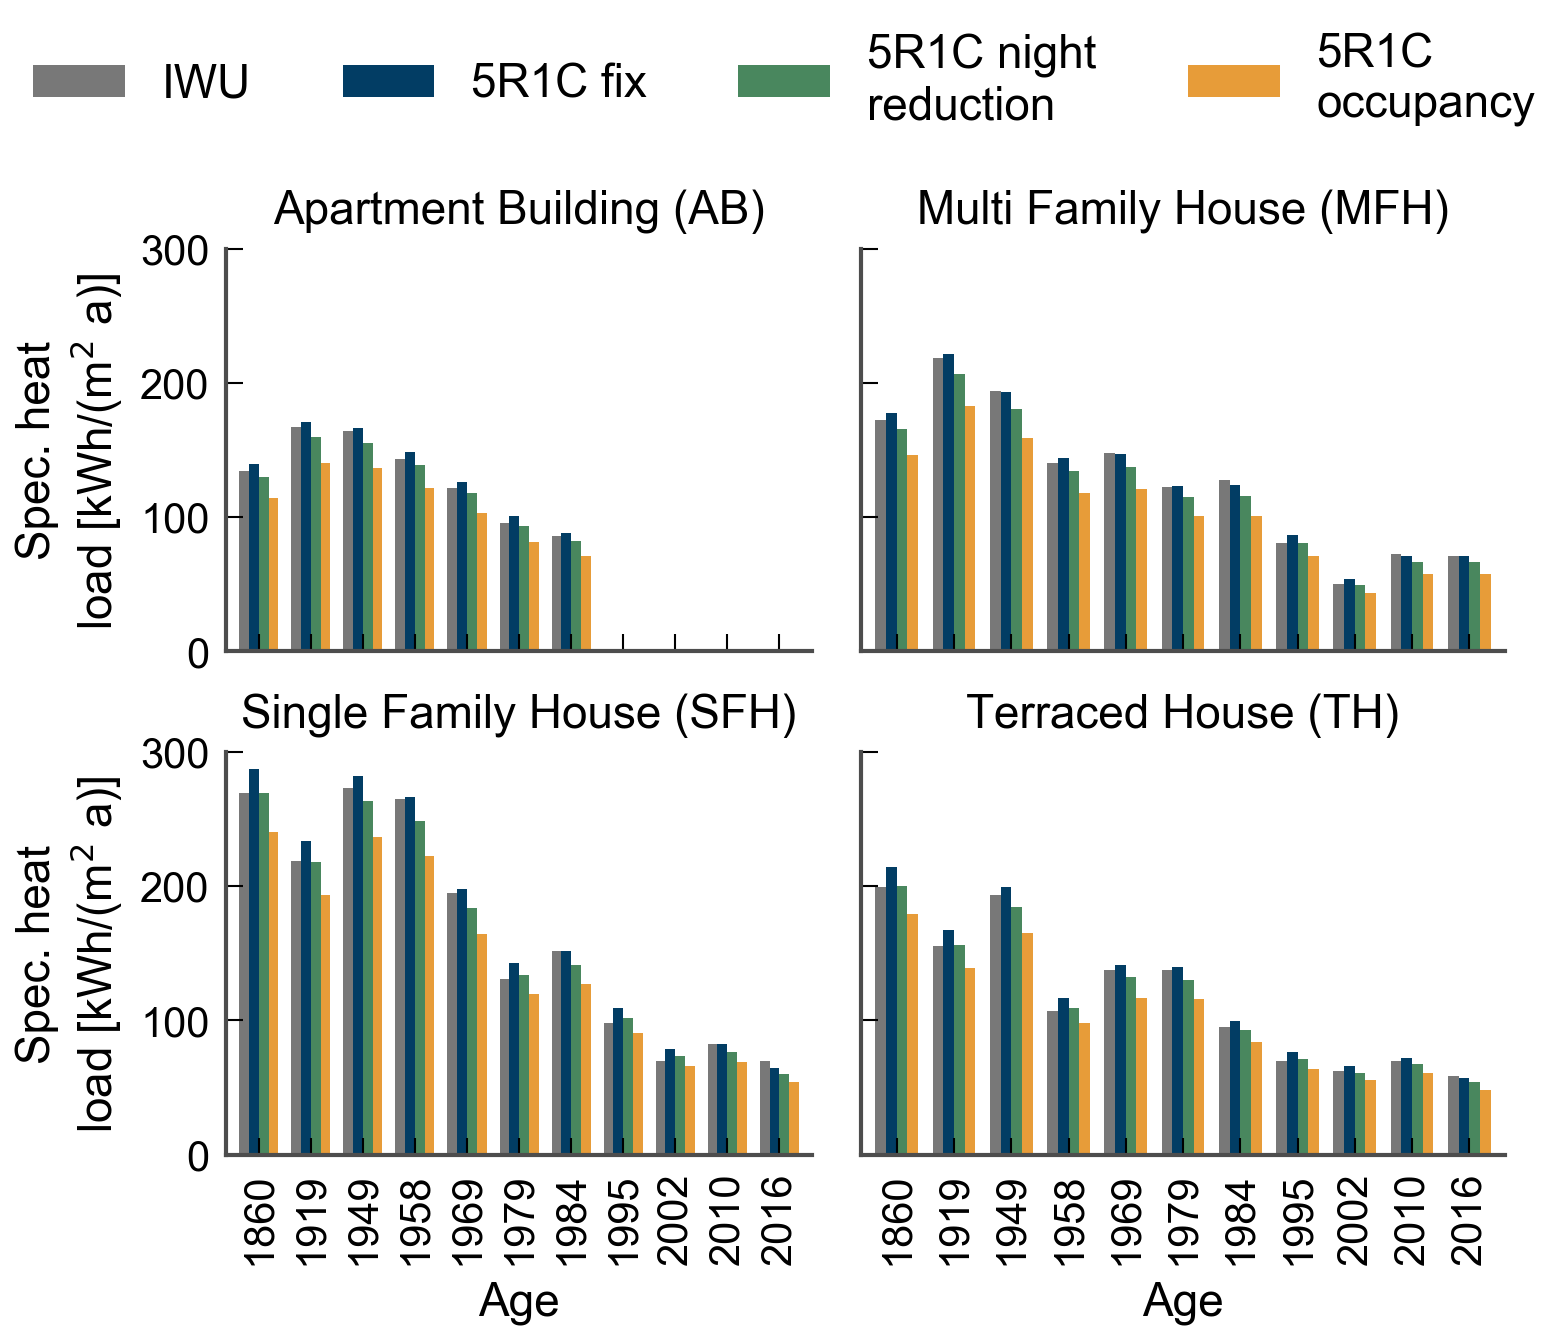

In [25]:
fig, axes = plt.subplots(figsize=[5.5,4], ncols = 2, nrows = 2, dpi = 300,
                         gridspec_kw = {'width_ratios':[1, 1.1],  
                                            'hspace': 0.25, 
                                            'wspace': 0.08})
COLORS = [np.array([120., 120., 120.,255.])/255,
          utils.CMAP_DISS(0.0),
          utils.CMAP_DISS(0.4),
          np.array([231., 156., 57.,255.])/255,]


for i,bType in enumerate(plotSet.index.levels[1]):
    ax = axes[int((i)/2)][int((i)%2)]
    c_set = plotSet[plotSet.index.get_level_values(level=1) == bType]
    c_set.index = c_set.index.droplevel(1).astype(int)
    c_set = c_set.ix[[1860, 1919, 1949, 1958, 1969,1979, 1984,
              1995, 2002, 2010, 2016]].sort_index()
    c_set = c_set.rename(columns = {'q_h_nd':'IWU','q_sim':'5R1C fix',
                                   'q_sim_night':'5R1C night\nreduction','q_sim_occ':'5R1C\noccupancy',})
    PLOT_SET = ['IWU','5R1C fix','5R1C night\nreduction','5R1C\noccupancy']
    if i == 0:
        c_set[PLOT_SET].plot(kind = 'bar', ax = ax,legend = False, width = 0.75, #,edgecolor = 'w', linewidth = 0.0, 
                                            colors = COLORS)    
    else:
        c_set[PLOT_SET].plot(kind = 'bar', ax = ax, legend = False,width = 0.75, #edgecolor = 'w', linewidth = 0.5,
                                            colors = COLORS,)     
    ax.set_ylim([0,300])
    ax.set_title(bType, fontsize = 11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if int(i)%2 == 0:
        ax.set_ylabel('Spec. heat\nload [kWh/(m$^2$ a)]')
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    if int(i/2) == 1:
        pass
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel('')

        
axes[0][0].legend(bbox_to_anchor=(-0.4, 1.2),loc= 'lower left',ncol = 4, fontsize = 11)
        
plt.savefig(os.path.join(EXPORT_PATH,'method_heatLoadValidation_new.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(EXPORT_PATH,'png','method_heatLoadValidation_new.png'), bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\ProgramData\Anaconda3\envs\recent\lib\site-packages\matplotlib\

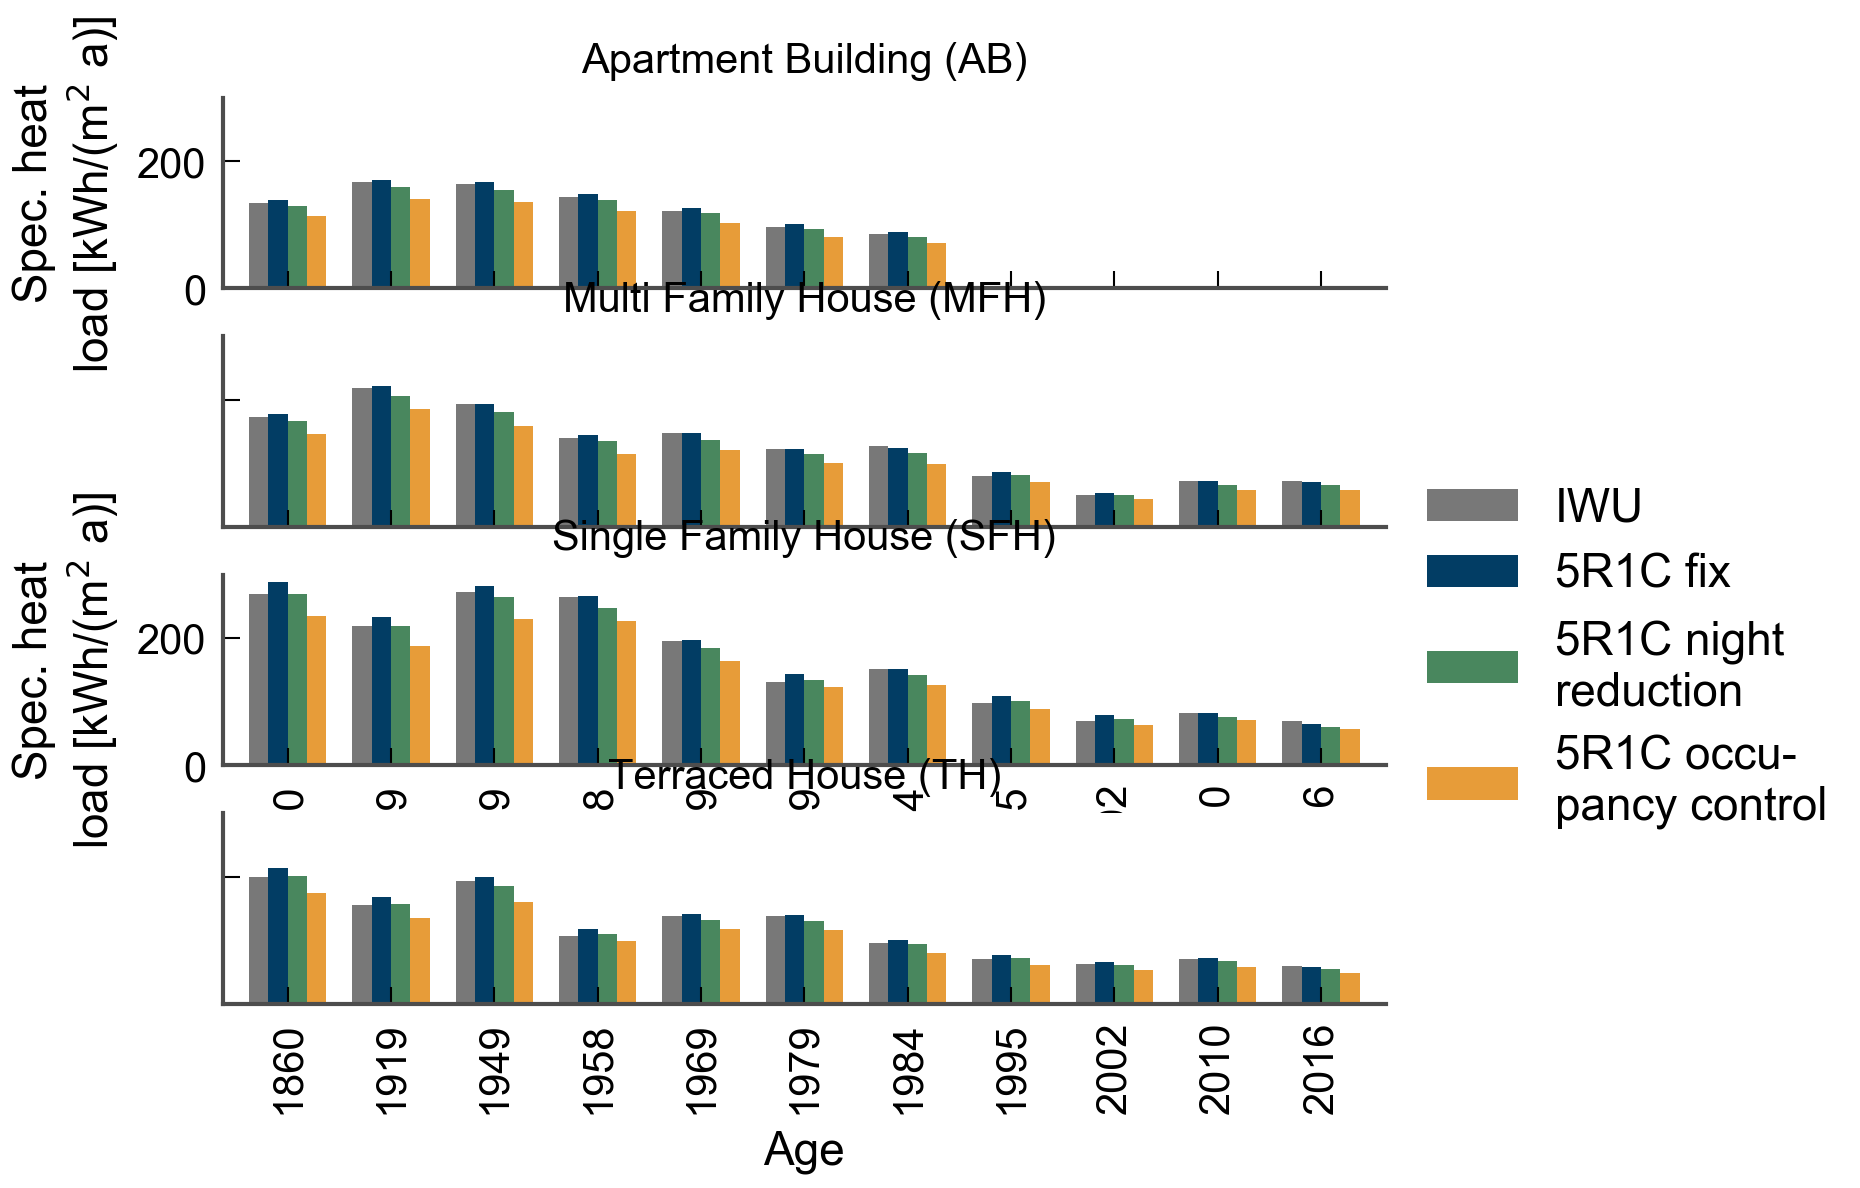

In [47]:
fig, axes = plt.subplots(figsize=[5,4], ncols = 1, nrows = 4, dpi = 300,
                         gridspec_kw = {    'hspace': 0.25, 
                                            'wspace': 0.08})
COLORS = [np.array([120., 120., 120.,255.])/255,
          utils.CMAP_DISS(0.0),
          utils.CMAP_DISS(0.4),
          np.array([231., 156., 57.,255.])/255,]


for i,bType in enumerate(plotSet.index.levels[1]):
    ax = axes[i]
    c_set = plotSet[plotSet.index.get_level_values(level=1) == bType]
    c_set.index = c_set.index.droplevel(1).astype(int)
    c_set = c_set.ix[[1860, 1919, 1949, 1958, 1969,1979, 1984,
              1995, 2002, 2010, 2016]].sort_index()
    c_set = c_set.rename(columns = {'q_h_nd':'IWU','q_sim':'5R1C fix',
                                   'q_sim_night':'5R1C night\nreduction','q_sim_occ':'5R1C occu-\npancy control',})
    PLOT_SET = ['IWU','5R1C fix','5R1C night\nreduction','5R1C occu-\npancy control']
    if i == 0:
        c_set[PLOT_SET].plot(kind = 'bar', ax = ax,legend = False, width = 0.75, #,edgecolor = 'w', linewidth = 0.0, 
                                            colors = COLORS)    
    else:
        c_set[PLOT_SET].plot(kind = 'bar', ax = ax, legend = False,width = 0.75, #edgecolor = 'w', linewidth = 0.5,
                                            colors = COLORS,)     
    ax.set_ylim([0,300])
    ax.set_title(bType, fontsize = 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if int(i)%2 == 0:
        ax.set_ylabel('Spec. heat\nload [kWh/(m$^2$ a)]')
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    if int(i/2) == 1:
        pass
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel('')

        
ax.legend(bbox_to_anchor=(1.0, .7),loc= 'lower left',)
        

plt.savefig(os.path.join(EXPORT_PATH,'method_heatLoadValidation_new.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(EXPORT_PATH,'png','method_heatLoadValidation_new.png'), bbox_inches='tight')

## Illustrate temperature tolerance

In [ ]:
import tsib.buildingconfig as cfg
import tsib.buildingmanager as bm

Test solar heat gain

In [ ]:
bdgcfg = cfg.BuildingConfiguration({'ID':'DE.N.SFH.11.Gen.ReEx.001.001', 
                                    'weather_data': try_data, 'weatherID': 'TRY_4',
                                       'refurbishment': False, 'nightReduction': True, 
                                       'ventControl ': False, 'occControl': True, 'capControl': True,
                                       'comfortT_lb': 21.0, 'comfortT_ub':24.0, 'n_persons': 2,})
bdgObj = bdg.Building(configurator = bdgcfg, refurbishment = False)
bdgObj.cfg['Q_ig'] = bdgObj.cfg['Q_ig'] * 15.552 / (bdgObj.cfg['Q_ig'].sum()/bdgObj.cfg['A_ref'])
bdgObj.sim_5R1C()  


In [ ]:
startdate = '201002'
bdgObj.detailed_results['T_out'] = bdgObj.cfg['weather']['T']
ax1 = bdgObj.detailed_results[['T_air','T_m']][startdate + '15':startdate + '17'].plot()
ax2 = ax1.twinx()
bdgObj.detailed_results[['Heating Load']][startdate + '15':startdate + '17'].plot(ax = ax2, 
                                                                     colors = np.array([192., 0., 0.,255.])/255)

In [ ]:
bdgcfg = cfg.BuildingConfiguration({'ID':'DE.N.SFH.11.Gen.ReEx.001.001', 
                                    'weather_data': try_data, 'weatherID': 'TRY_4',
                                       'refurbishment': False, 'nightReduction': False, 
                                       'ventControl ': False, 'occControl': False, 'capControl': True,
                                       'comfortT_lb': 20.0, 'comfortT_ub':26, 'n_persons': 2,})
bdgObj2 = bdg.Building(configurator = bdgcfg, refurbishment = False)
bdgObj2.cfg['Q_ig'] = bdgObj2.cfg['Q_ig'] * 15.552 / (bdgObj.cfg['Q_ig'].sum()/bdgObj.cfg['A_ref'])
bdgObj2.sim_5R1C()

In [ ]:
bdgObj2.detailed_results['T_out'] = bdgObj.cfg['weather']['T']
ax1 = bdgObj2.detailed_results[['T_air','T_m']]['20100115':'20100117'].plot()
ax2 = ax1.twinx()
bdgObj2.detailed_results[['Heating Load']]['20100115':'20100117'].plot(ax = ax2, 
                                                                     colors = np.array([192., 0., 0.,255.])/255)

Get occupancy profile

In [ ]:
occ_home = 1 - bdgcfg.cfg['occ_nothome'] - bdgcfg.cfg['occ_sleeping']

In [ ]:
occ = pd.DataFrame([bdgcfg.cfg['occ_nothome'],occ_home,bdgcfg.cfg['occ_sleeping']],
                    index = ['Vacant', 'Active', 'Sleeping']).T

In [ ]:
occ.index = pd.to_datetime(occ.index)

In [ ]:
import matplotlib.dates as mdates

In [ ]:
fig, axes = plt.subplots(figsize=[160./25.4,6], ncols = 1, nrows = 4, dpi = 300,
                         gridspec_kw = {'hspace': 0.2,})
# occupancy
ax = axes[0]
occ[startdate + '15':startdate + '17'].plot.area(ax = ax, use_index = False,
                                                       colors = [ np.array([231., 156., 57.,255.])/255,
                                                                    np.array([108., 139., 57.,255.])/255,
                                                                    np.array([2., 61., 100.,255.])/255,],)
#plt.xticks([])
plt.setp(ax.get_xticklabels(), visible=False, )
ax.set_ylabel('Share occ.\nactivity\n[-]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# plot t _air
ax = axes[1]

bdgObj2.detailed_results['T_air'][startdate + '15':startdate + '17'].plot(ax = ax, color = np.array([2., 61., 100.,255.])/255,
                                                                         lw = 1.5,
                                                                       label = 'fix demand')
bdgObj.detailed_results['T_air'][startdate + '15':startdate + '17'].plot(ax = ax, lw=1.5,
                                                                       label = 'with control', 
                                                                       color = np.array([231., 156., 57.,255.])/255,)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Air \ntemp.\n[°C]')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([13,25])

# plot t _m
ax = axes[2]

bdgObj2.detailed_results['T_m'][startdate + '15':startdate + '17'].plot(ax = ax,color = np.array([2., 61., 100.,255.])/255,
                                                                       label = 'fix demand')
bdgObj.detailed_results['T_m'][startdate + '15':startdate + '17'].plot(ax = ax,lw=1.5,
                                                                       label = 'with control', 
                                                                       color = np.array([231., 156., 57.,255.])/255,)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Mass\ntemp.\n[°C]')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([14,20])


# heat load t _m
ax = axes[3]

bdgObj2.detailed_results['Heating Load'][startdate + '15':startdate + '17'].plot(ax = ax, color = np.array([2., 61., 100.,255.])/255,
                                                                                lw=1.5,
                                                                       label = 'fix demand')
bdgObj.detailed_results['Heating Load'][startdate + '15':startdate + '17'].plot(ax = ax, lw=1.5,
                                                                       label = 'with control', 
                                                                       color = np.array([231., 156., 57.,255.])/255,)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Heat\nload\n[kW]')
ax.set_ylim([0,13])
ticks = ax.get_xticklabels()
ax.set_xticklabels(ticks,rotation=0, ha='center')

myFmt = mdates.DateFormatter('%H:%M\n%d-%b')
ax.xaxis.set_major_formatter(myFmt)

plt.savefig(os.path.join(EXPORT_PATH,'method_heatLoadDynamic.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(EXPORT_PATH,'png','method_heatLoadDynamic.png'), bbox_inches='tight')

In [ ]:
M = bdgObj.M

In [ ]:
Expression_values = dict((idx, c.body) for idx, c in M.temperatureUBCon.iteritems())

In [ ]:
from pyomo.environ import value

In [ ]:
for (t1,t2) in bdgObj.M.timeIndex[:12]:
    ctemp = M.bT_air[t1, t2].value
    print(str(ctemp - value(M.temperatureLBCon[t1,t2].body))+ ' < ' +
        str(ctemp) + ' < ' 
          +str(ctemp - value(M.temperatureUBCon[t1,t2].body)))